In [2]:
%pip install matplotlib
%pip install pandas
%pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from torch import Tensor
from typing import Tuple
from torch import optim
from time import time
from torch import nn
import pandas as pd
import torch

In [3]:
torch.manual_seed(42)

# Подготовка данных

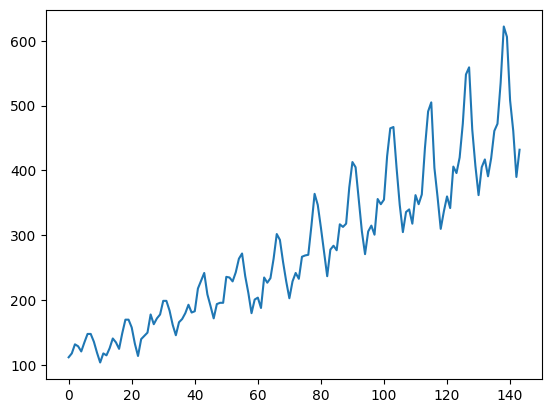

In [9]:
df = pd.read_csv('airline-passengers.csv')
dataset = df[["Passengers"]].values.astype('float32')
 
plt.plot(dataset)
plt.show()

In [11]:
def create_dataset(dataset: Dataset, lookback: int) -> Tuple[Tensor, Tensor]:
    """

    Принимает на вход:
        - dataset: Датасет для предобработки
        - lookback: Количество одновременно подаваемых данных

    Выводит на выходе:
        - Tuple:
            - x: Обучающая выборка
            - y: Верные ответы

    Примеры:

    In: >>> create_dataset(TensorDataset(torch.tensor([1, 2, 3])), 1)
    Out: (tensor([[1],
                  [2]]),
          tensor([[2],
                  [3]]))
    
    """

    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)

    return torch.tensor(X), torch.tensor(y)

In [12]:
LOOKBACK: int = 3                       # Сколько точек данных видит модель за раз
TRAIN_SIZE: float = 0.8                 # Сколько процентов датасета в обучающей выборке
BATCH_SIZE: int = 8                    # Количество элементов в батче

full_dataset = dataset
train_dataset, test_dataset = random_split(full_dataset, [TRAIN_SIZE, 1 - TRAIN_SIZE])
train_dataloader = DataLoader(TensorDataset(*create_dataset(train_dataset, LOOKBACK)), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(TensorDataset(*create_dataset(test_dataset, LOOKBACK)), batch_size=BATCH_SIZE, shuffle=True)
next(iter(train_dataloader)), next(iter(test_dataloader))

C:\Users\Борн\AppData\Local\Temp\ipykernel_15348\594415000.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(X), torch.tensor(y)


([tensor([[[218.],
           [191.],
           [178.]],
  
          [[172.],
           [271.],
           [172.]],
  
          [[259.],
           [196.],
           [315.]],
  
          [[505.],
           [362.],
           [301.]],
  
          [[342.],
           [229.],
           [233.]],
  
          [[305.],
           [115.],
           [293.]],
  
          [[170.],
           [432.],
           [211.]],
  
          [[126.],
           [148.],
           [491.]]]),
  tensor([[[191.],
           [178.],
           [140.]],
  
          [[271.],
           [172.],
           [278.]],
  
          [[196.],
           [315.],
           [336.]],
  
          [[362.],
           [301.],
           [237.]],
  
          [[229.],
           [233.],
           [199.]],
  
          [[115.],
           [293.],
           [196.]],
  
          [[432.],
           [211.],
           [112.]],
  
          [[148.],
           [491.],
           [535.]]])],
 [tensor([[[135.],
      

# Моделька

In [13]:
class BaseNextWordPredictNet(nn.Module):
    def __init__(self,
                 hidden_size: int,
                 num_layers: int):

        super().__init__()

        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
model = BaseNextWordPredictNet(
    hidden_size=256,
    num_layers=8,
)

model

BaseNextWordPredictNet(
  (lstm): LSTM(1, 256, num_layers=4, batch_first=True)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

# Обучение

In [15]:
EPOCHS: int = 100
LR: float = 0.001

train_losses = []
test_losses = []
epochs = 0

In [16]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

model.train()

for epoch in range(EPOCHS):
    epochs += 1
    model.train()

    total_train_loss = 0
    total_test_loss = 0

    for X, y in train_dataloader:
        y_pred = model(X)

        train_loss = loss_fn(y_pred, y)
        total_train_loss += train_loss.item()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for X, y in test_dataloader:
            y_pred = model(X)

            test_loss = loss_fn(y_pred, y)
            total_test_loss += test_loss.item()

    train_losses.append(total_train_loss / len(train_dataloader))
    test_losses.append(total_test_loss / len(test_dataloader))

    print(f"Epoch: {epochs} / {EPOCHS * ((epochs - 1) // EPOCHS) + EPOCHS} Train loss: {round(total_train_loss / len(train_dataloader), 3)} Validation loss: {round(total_test_loss / len(test_dataloader), 3)}", end="                                             \r", flush=True)

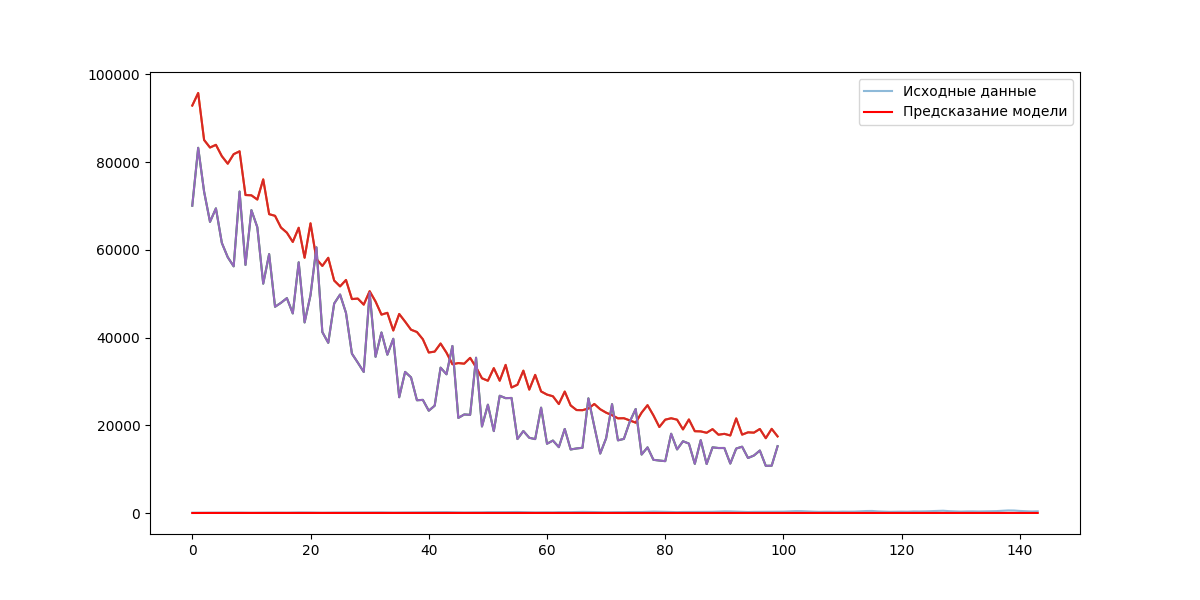

In [33]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

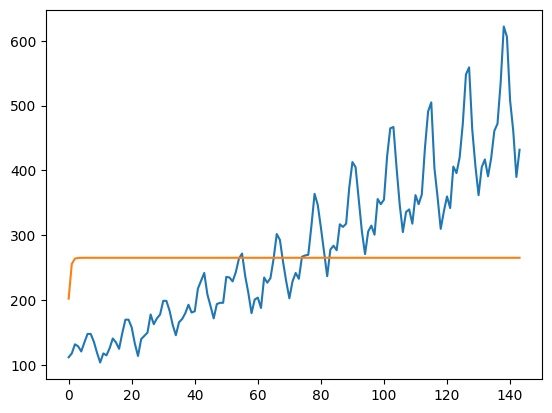

Inference time: 44.5709228515625 ms


In [21]:
start = time()
model.eval()

with torch.no_grad():
    prediction = model(torch.tensor(dataset))

end = time()
plt.plot(dataset)
plt.plot(prediction)
plt.show()
print(f"Inference time: {(end - start) * 1000} ms")